<a href="https://colab.research.google.com/github/aaubs/ds-master/blob/main/notebooks/M3_Character_Level_LSTM_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import required libraries
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests

In [2]:
response = requests.get('https://raw.githubusercontent.com/aaubs/ds-master/main/data/Character_Level_LSTM_PyTorch.txt')

with open("text.txt", "w") as f:
    f.write(response.text)

with open("text.txt", "r") as f:
    text = f.read()


In [3]:
len(text)

1985223

In [4]:
text = text.replace('\n', ' ').replace("\'", '')
text = text.lower()

In [5]:
import numpy as np

# encode the text and map each character to an integer and vice versa

# we create two dictonaries:
# 1. int2char, which maps integers to characters
# 2. char2int, which maps characters to unique integers

chars = tuple(set(text))

int2char = dict(enumerate(chars))

char2int = {ch: ii for ii, ch in int2char.items()}

encoded = np.array([char2int[ch] for ch in text])

In [6]:
int2char.items()

dict_items([(0, ' '), (1, 'o'), (2, 'j'), (3, 'u'), (4, 'm'), (5, 'p'), (6, 'y'), (7, 'q'), (8, '@'), (9, ';'), (10, 'r'), (11, '%'), (12, '('), (13, '`'), (14, 's'), (15, 'h'), (16, '5'), (17, '-'), (18, '"'), (19, 'z'), (20, 'i'), (21, '*'), (22, 'b'), (23, ':'), (24, '6'), (25, '1'), (26, '_'), (27, ','), (28, '7'), (29, 'a'), (30, 'e'), (31, 'd'), (32, '3'), (33, 'x'), (34, '/'), (35, '&'), (36, 'k'), (37, 'v'), (38, '4'), (39, '8'), (40, '!'), (41, 'g'), (42, ')'), (43, '.'), (44, 'n'), (45, 'f'), (46, 'l'), (47, 'w'), (48, '$'), (49, 't'), (50, 'c'), (51, '9'), (52, '0'), (53, '2'), (54, '?')])

In [7]:
char2int.items()

dict_items([(' ', 0), ('o', 1), ('j', 2), ('u', 3), ('m', 4), ('p', 5), ('y', 6), ('q', 7), ('@', 8), (';', 9), ('r', 10), ('%', 11), ('(', 12), ('`', 13), ('s', 14), ('h', 15), ('5', 16), ('-', 17), ('"', 18), ('z', 19), ('i', 20), ('*', 21), ('b', 22), (':', 23), ('6', 24), ('1', 25), ('_', 26), (',', 27), ('7', 28), ('a', 29), ('e', 30), ('d', 31), ('3', 32), ('x', 33), ('/', 34), ('&', 35), ('k', 36), ('v', 37), ('4', 38), ('8', 39), ('!', 40), ('g', 41), (')', 42), ('.', 43), ('n', 44), ('f', 45), ('l', 46), ('w', 47), ('$', 48), ('t', 49), ('c', 50), ('9', 51), ('0', 52), ('2', 53), ('?', 54)])

In [8]:
encoded.shape

(1978502,)

In [9]:
def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

In [10]:
# check that the function works as expected
test_seq = np.array([[3, 5, 1]])
one_hot = one_hot_encode(test_seq, 8)

print(type(one_hot))
print(one_hot)

<class 'numpy.ndarray'>
[[[0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0.]]]


In [11]:
# Split the data into sequences for LSTM input
n_steps = 100
sequence_data = []
sequence_labels = []

for i in range(len(encoded) - n_steps):
    sequence_data.append(encoded[i:i+n_steps])
    sequence_labels.append(encoded[i+n_steps])

sequence_data = np.array(sequence_data)
sequence_labels = np.array(sequence_labels)

train_data = sequence_data[:15000]
train_labels = sequence_labels[:15000]
test_data = sequence_data[15000:16000]
test_labels = sequence_labels[15000:16000]

In [12]:
# Split the data into training and testing sets
train_data = TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_labels))
test_data = TensorDataset(torch.from_numpy(test_data), torch.from_numpy(test_labels))

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [13]:

# Initialize the LSTM model
# Define the input size, hidden size and number of outputs
input_size = len(chars)
hidden_size = 128
output_size = len(chars)
n_layers = 1
drop_prob = 0.5
num_epochs= 10

# 1. Creating a LSTM model
# Define the LSTM model and Linear output fully connected layer
lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)
fc = nn.Linear(hidden_size, output_size)
softmax = nn.Softmax(dim=-1)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(lstm.parameters(), lr=0.01)

In [14]:
# Combine the parameters of the LSTM layer and linear layer
params = list(lstm.parameters()) + list(fc.parameters())

# Print the number of parameters
print("Number of parameters:", sum(p.numel() for p in params))

# Print the shapes of the parameters
for name, param in lstm.named_parameters():
    print("Name: ", name)
    print("shape: ", param.shape)
    # print("Weight: ", param.data)
     

Number of parameters: 101815
Name:  weight_ih_l0
shape:  torch.Size([512, 55])
Name:  weight_hh_l0
shape:  torch.Size([512, 128])
Name:  bias_ih_l0
shape:  torch.Size([512])
Name:  bias_hh_l0
shape:  torch.Size([512])


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1, 55])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 6/6 [57:06<00:00, 571.04s/it]


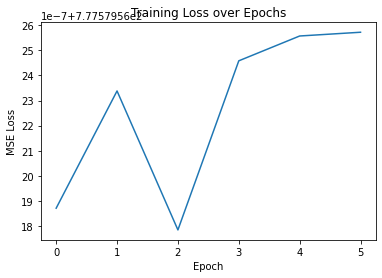

In [15]:
# Initializing Hyperparameters
num_epochs = 6
train_losses = []
test_losses = []

# Loop over the number of epochs
for epoch in tqdm(range(num_epochs)):
    train_loss = 0

    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, 1, hidden_size)
    cs = torch.zeros(1, 1, hidden_size)
    
    # Get the input and target at position i
    for i, (data, label) in enumerate(train_loader):
        
        hidden = (hs, cs)

        # One-hot encode our data and make them Torch tensors
        data = one_hot_encode(data, len(chars))
        data = torch.from_numpy(data)
        data.requires_grad = True

        # Run the forward pass
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])
        output = softmax(output)
        predicted = torch.argmax(output.data)

        
        # 2. Network Evaluation
        loss = criterion(output, label[0].float())
        hs = hs.detach()
        cs = cs.detach()

        # 3. Gradient Calculation
        loss.backward()

        # 4. Back Propagation
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    # Calculate the average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

# Plot the MSE loss for each epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [482]:
# Evaluate the LSTM model
mse = 0

with torch.no_grad():
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, 1, hidden_size)
    cs = torch.zeros(1, 1, hidden_size)

    for data, label in test_loader:
        
        hidden = (hs, cs)
        # One-hot encode our data and make them Torch tensors
        data = one_hot_encode(data, len(chars))
        data = torch.from_numpy(data)
        data.requires_grad = True

        # Run the forward pass
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])
        output = softmax(output)
        predicted = torch.argmax(output.data)

        hs = hs.detach()
        cs = cs.detach()

        mse += ((output - label)**2).mean().item()

mse /= len(test_loader)
print('Test MSE: {}'.format(mse))

Test MSE: 746.794254680872


In [483]:
model_dante = 'lstm_6_epoch.net'

checkpoint = {'n_hidden': hidden_size,
              'n_layers': n_layers,
              'state_dict': lstm.state_dict(),
              'tokens': len(chars)}

with open(model_dante, 'wb') as f:
    torch.save(checkpoint, f)

In [484]:
# Here we have loaded in a model that trained over 20 epochs `rnn_20_epoch.net`
with open('lstm_6_epoch.net', 'rb') as f:
    checkpoint = torch.load(f)
    
loaded = torch.nn.LSTM(checkpoint['tokens'], checkpoint['n_hidden'], checkpoint['n_layers'])
loaded.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [485]:
test_data_new = sequence_data[160000:160100]
test_labels_new = sequence_labels[160000:160100]

In [486]:
# Split the data into training and testing sets
test_data_new = TensorDataset(torch.from_numpy(test_data_new), torch.from_numpy(test_labels_new))
test_loader_new= DataLoader(test_data_new, batch_size=1, shuffle=False)

In [487]:
output_list = []

for i, (data, label) in enumerate(test_loader_new):
  hidden = (hs, cs)
  # One-hot encode our data and make them Torch tensors
  data = one_hot_encode(data, len(chars))
  data = torch.from_numpy(data)
  data.requires_grad = True

  # Run the forward pass
  output, hidden = lstm(data.float(), hidden)
  output = fc(hidden[-1])
  output = softmax(output)
  predicted = torch.argmax(output.data)
  output_list.append(int(predicted))

In [489]:
output_list_keys = []
for key in output_list:
    output_list_keys.append(int2char[key])
print(output_list_keys[:100])

['h', '`', '`', '`', '`', 'h', '`', '`', '`', '`', 'k', 'k', 'h', '`', '`', '`', '`', 'h', 'k', 'k', 'k', 'k', '`', '`', '`', '.', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', 'k', 'k', 'k', '`', '`', '`', '.', 'k', '`', '`', 'k', 'k', 'k', '`', '`', '`', '`', 'k', 'k', 'k', 'h', '`', '`', '`', '`', '`', '`', '`', '`', 'k', '`', '`', '`', '`', '`', '`', '`', '`', '`', 'h', '`', '`', '`', '`', 'k', 'k', 'k', '`', '`', '`', 'k', 'k', 'k', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`']
